It seems that Viking 2 has a completely different encoding. This notebook explores the Viking 2 encoding.

Viking GCMS instrument data exploration and parsing
Casey Handmer
March 2019

In [5]:
import numpy as np
from matplotlib import pyplot as plt

Why start with the uncompressed files? They are nearly twice as big!

Uncompressed files typically retain structure, while good compression algorithms (of which there are hundreds) remove structure. Without knowing how compression was done, an uncompressed file is, I think, the best place to start.

In [7]:
with open("./Digital-files-raw-from-NSSDCA/5967 (VL-2)/DR005967_F00001.PHYS","rb") as f:
    rawdata = f.read()

Let's take a quick look at the data. This command outputs a string of hex symbols, which is a common way to represent binary data. Each hex symbol represents 4 bits, each pair a single byte. Most modern computers represent numbers with 64 bits (8 bytes) for double precision floats and ints.

In [16]:
len(rawdata)/8

399852.5

In [9]:
rawdata[:20]

b'x\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'

Of course we don't know how the data was encoded, but ints are a good place to start. Here are the first 500 bytes as unsigned short ints (0-255). This is probably the simplest non-trivial numerical encoding. Unlike Viking 1, the data isn't obviously periodic over short time scales. It does seem to have around 50 repeating segments with a period of about 64000 bits each.

In [11]:
from matplotlib import pyplot as plt

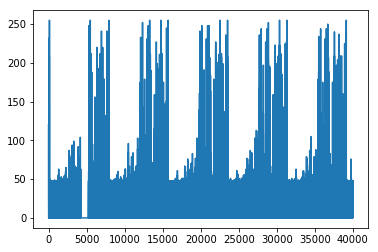

In [17]:
plt.plot([rawdata[i] for i in range(40000)])

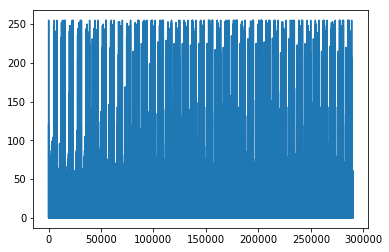

In [18]:
plt.plot([rawdata[i] for i in range(290000)])

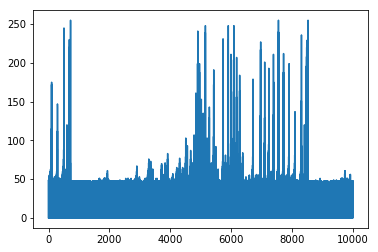

In [19]:
plt.plot([rawdata[i] for i in range(15000,25000)])

By inspection, the data has a periodicity of around 8000 bytes. My assumption is, therefore, that the data from the Viking GCMS is encoded in a sequence of data "frames", each of which has a header and a body containing data.

To determine the period, I'm going to examine stream correlation with different periods. One could also perform a Fourier transform or just guess a few times and check. 

I'm also going to perform all subsequent analysis in pure binary, because one of the instrument papers mentioned a 9-bit encoding, and there's no guarantee that the data frame will line up with the edge of the chosen byte!

There should be a better way of doing this, but I'm blanking on it.

In [20]:
rawbin=np.array([[(rawdata[j]%2**(8-i))//2**(7-i) for i in range(8)] for j in range(len(rawdata))]).reshape(8*len(rawdata))

In [24]:
rawbin[:1000]

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Compute the mean of the variance of slices of a range of lengths through the data. The underlying period will jump out at us. This takes a few minutes to crunch, don't panic.

In [29]:
variancearray1=[np.mean(np.var(rawbin[:a*10].reshape((10,a)),axis=0)) for a in range(1,64000)]

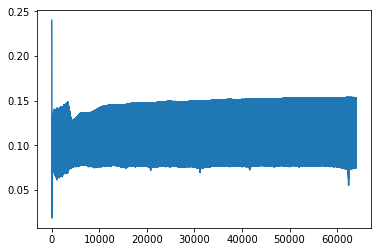

In [30]:
plt.plot(variancearray1)

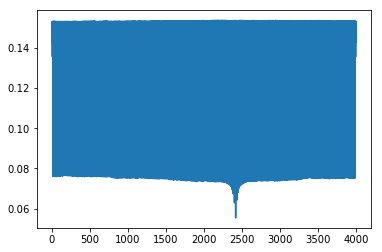

In [31]:
plt.plot(variancearray1[60000:])

In [52]:
np.where(variancearray1==np.min(variancearray1))[0][0]

37

In [33]:
np.where(variancearray1==np.min(variancearray1[60000:]))[0][0]

62415

In [34]:
period1 = 62416

Of course, there is some freedom in deciding where packets begin and end, since it's possible that the raw data file might have "cut off" the beginning of the first frame. So it is useful to look at the data and see where it varies.

This graph shows above the horizontal axis the parts of the frame where the data varies. Below the axis is the underlying binary data. Some of this is changing, some isn't. The stuff that isn't might be sample headers, date, spacecraft ID, and other stuff that, while interesting, is of secondary importance at this point. 

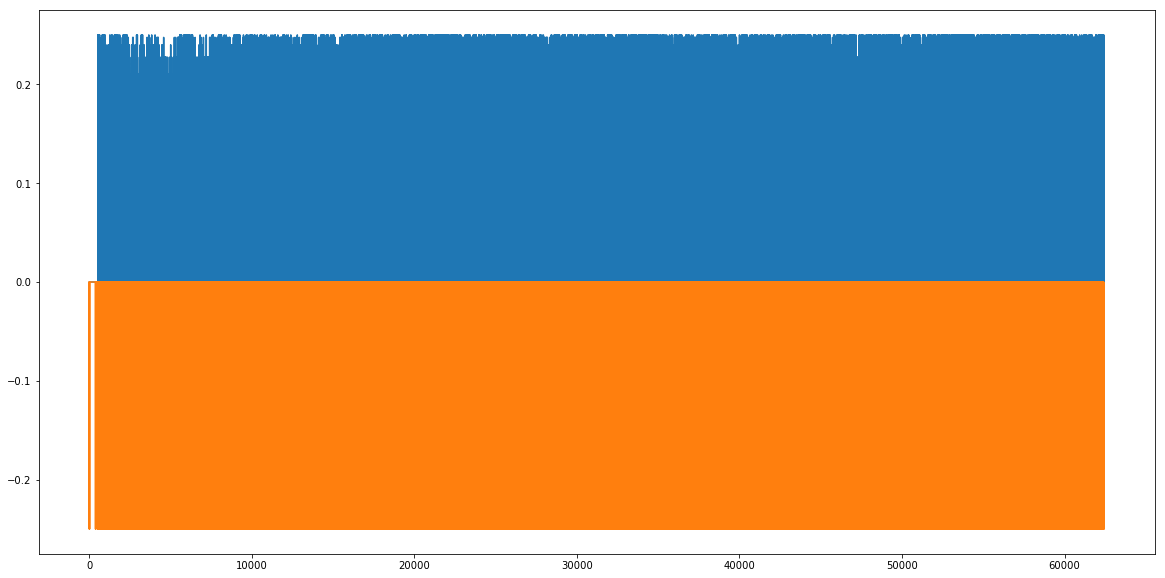

In [38]:
plt.figure(figsize=(20,10))
plt.plot(np.var(rawbin[:period1*20].reshape((20,period1)),axis=0))
plt.plot(-0.25*rawbin[period1:2*period1])

The variational structure of the data only becomes obvious when we don't try to plot 64000 data points with 1000 pixels. 

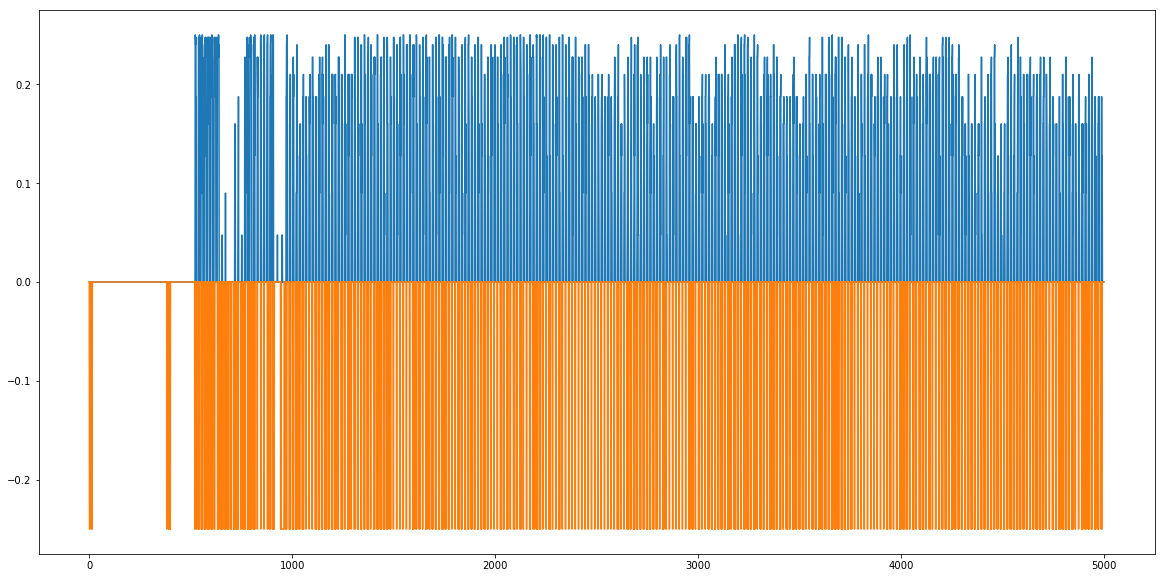

In [41]:
plt.figure(figsize=(20,10))
plt.plot(np.var(rawbin[:period1*20].reshape((20,period1)),axis=0)[:5000])
plt.plot(-0.25*rawbin[period1:2*period1][:5000])

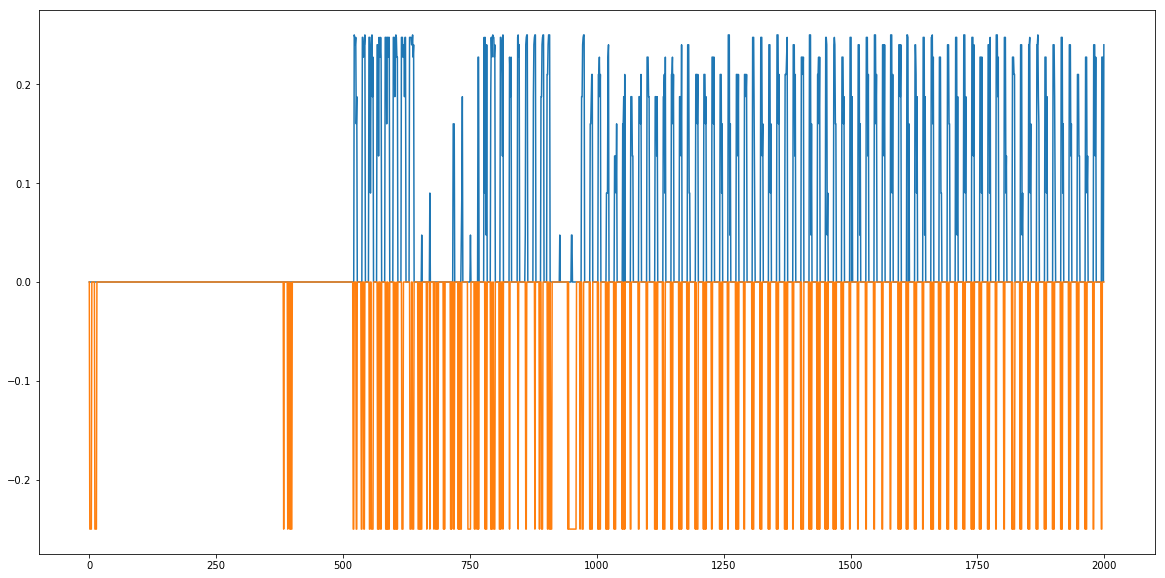

In [42]:
plt.figure(figsize=(20,10))
plt.plot(np.var(rawbin[:period1*20].reshape((20,period1)),axis=0)[:2000])
plt.plot(-0.25*rawbin[period1:2*period1][:2000])

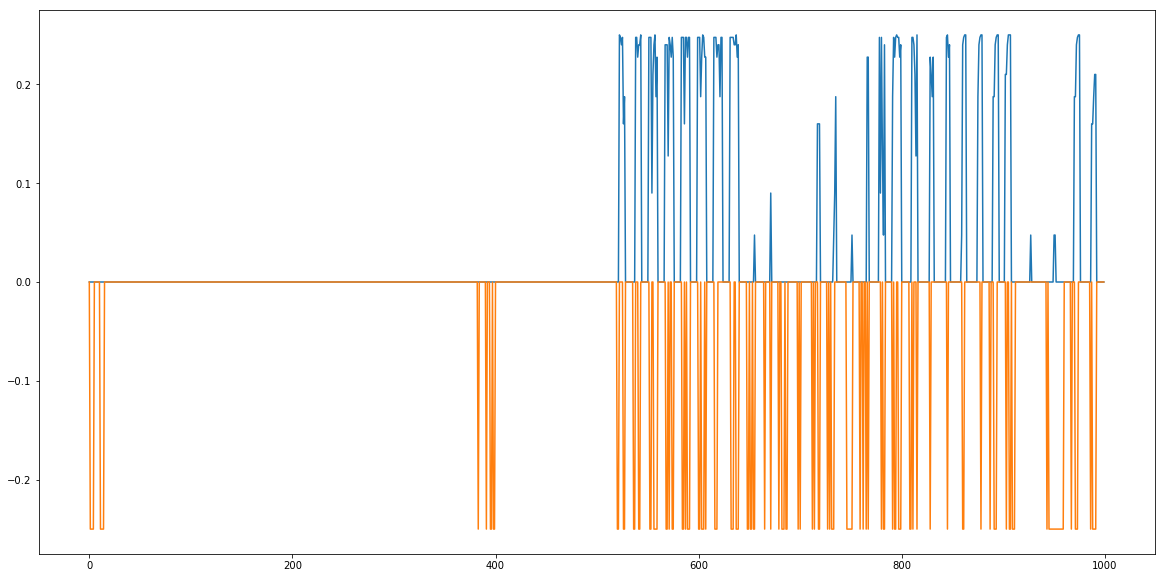

In [43]:
plt.figure(figsize=(20,10))
plt.plot(np.var(rawbin[:period1*20].reshape((20,period1)),axis=0)[:1000])
plt.plot(-0.25*rawbin[period1:2*period1][:1000])

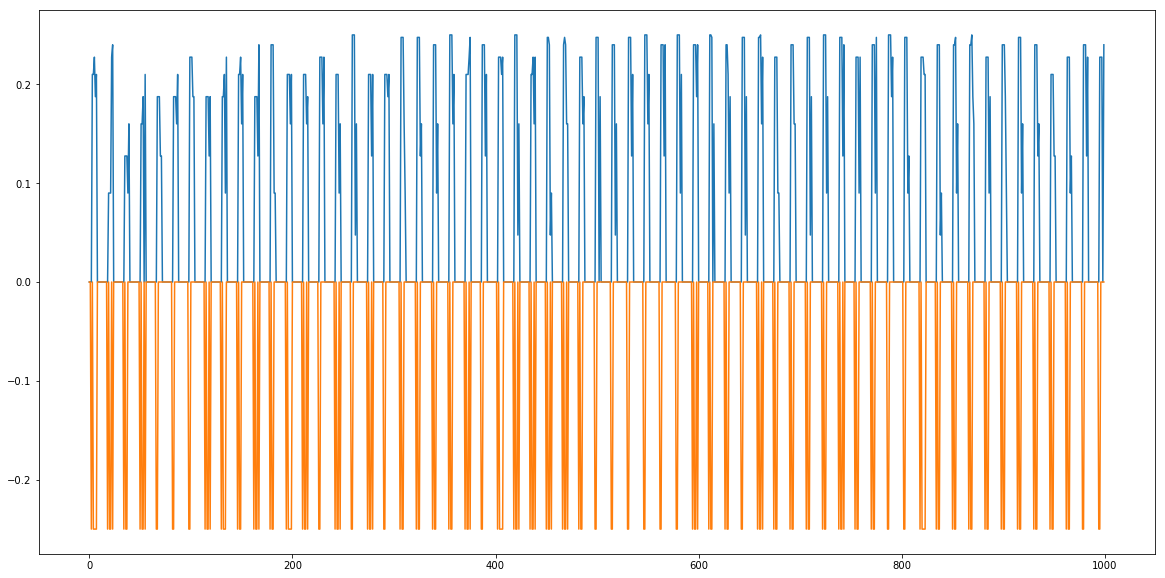

In [44]:
plt.figure(figsize=(20,10))
plt.plot(np.var(rawbin[:period1*20].reshape((20,period1)),axis=0)[1000:2000])
plt.plot(-0.25*rawbin[period1:2*period1][1000:2000])

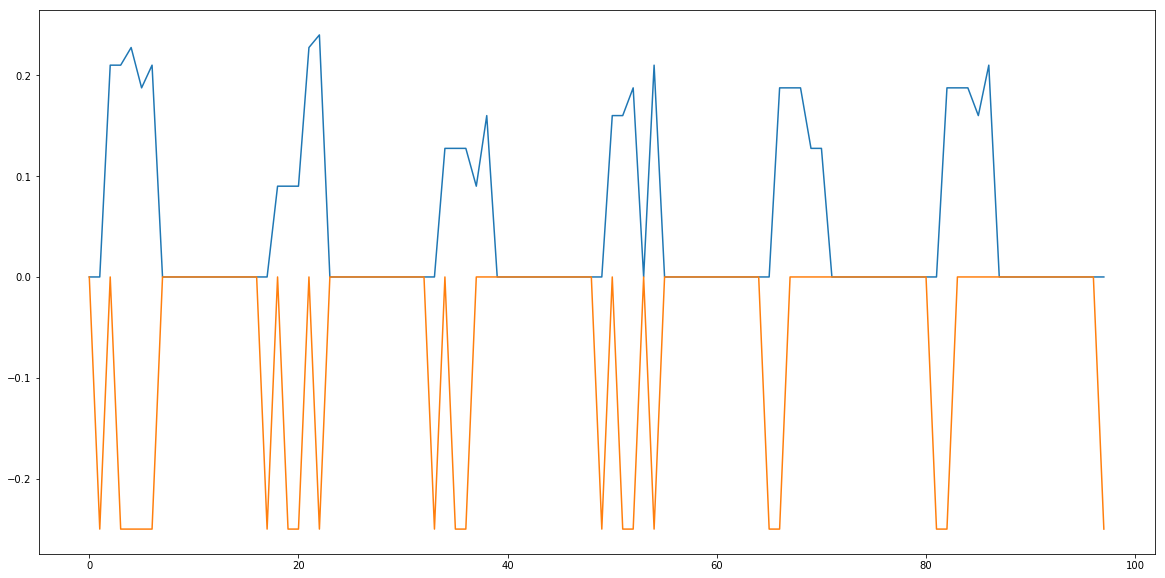

In [62]:
plt.figure(figsize=(20,10))
plt.plot(np.var(rawbin[:period1*20].reshape((20,period1)),axis=0)[1001:1002+6*16+1])
plt.plot(-0.25*rawbin[period1:2*period1][1001:1002+6*16+1])

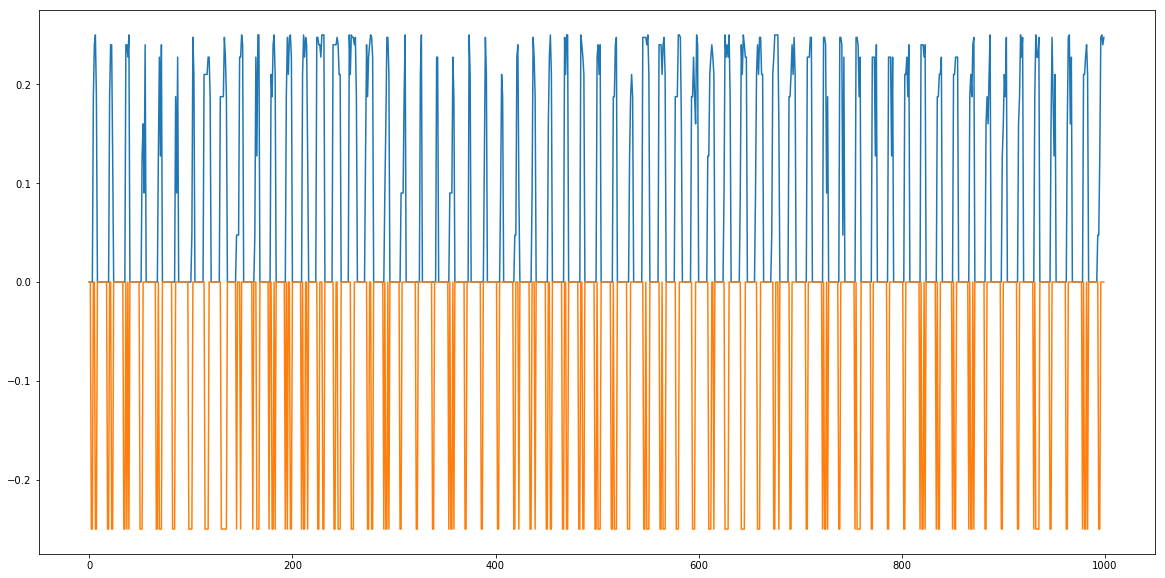

In [46]:
plt.figure(figsize=(20,10))
plt.plot(np.var(rawbin[:period1*20].reshape((20,period1)),axis=0)[31000:32000])
plt.plot(-0.25*rawbin[period1:2*period1][31000:32000])

The data seems to consist of 7802 byte data frames. The first 64 bytes or so are some sort of unchanging ID. The next 64 bytes are probably header, followed by 7674 bytes of body data. The body seems to be coded in 2 byte chunks, leaving room for 3837 9 bit values. 

Recall that the mass spec performs 10 second scans assessing 3840 ion current values. It does a few hundred of these scans, and the total space available implies room for about 410 or so complete scans in a sample. 

This is a graphical representation of the second 64 bytes in each of the 8000 byte data frames. Several salient features are worth pointing out.

First, the data is ordered and nice. Our periodic interpretation is correct. 

Second, there are about 28 data channels. Some of these are obnoxiously obviously binary counters. Others probably contain telemetry for oven temperature.

Third, the last three channels in this diagram are quite obviously part of the data frame body, and represent the missing 3 channels required to bring the total from 3837 to 3840 ion current measurements per scan.

Fourth, there are aspects of the start up and shut down procedure visible in the data. 

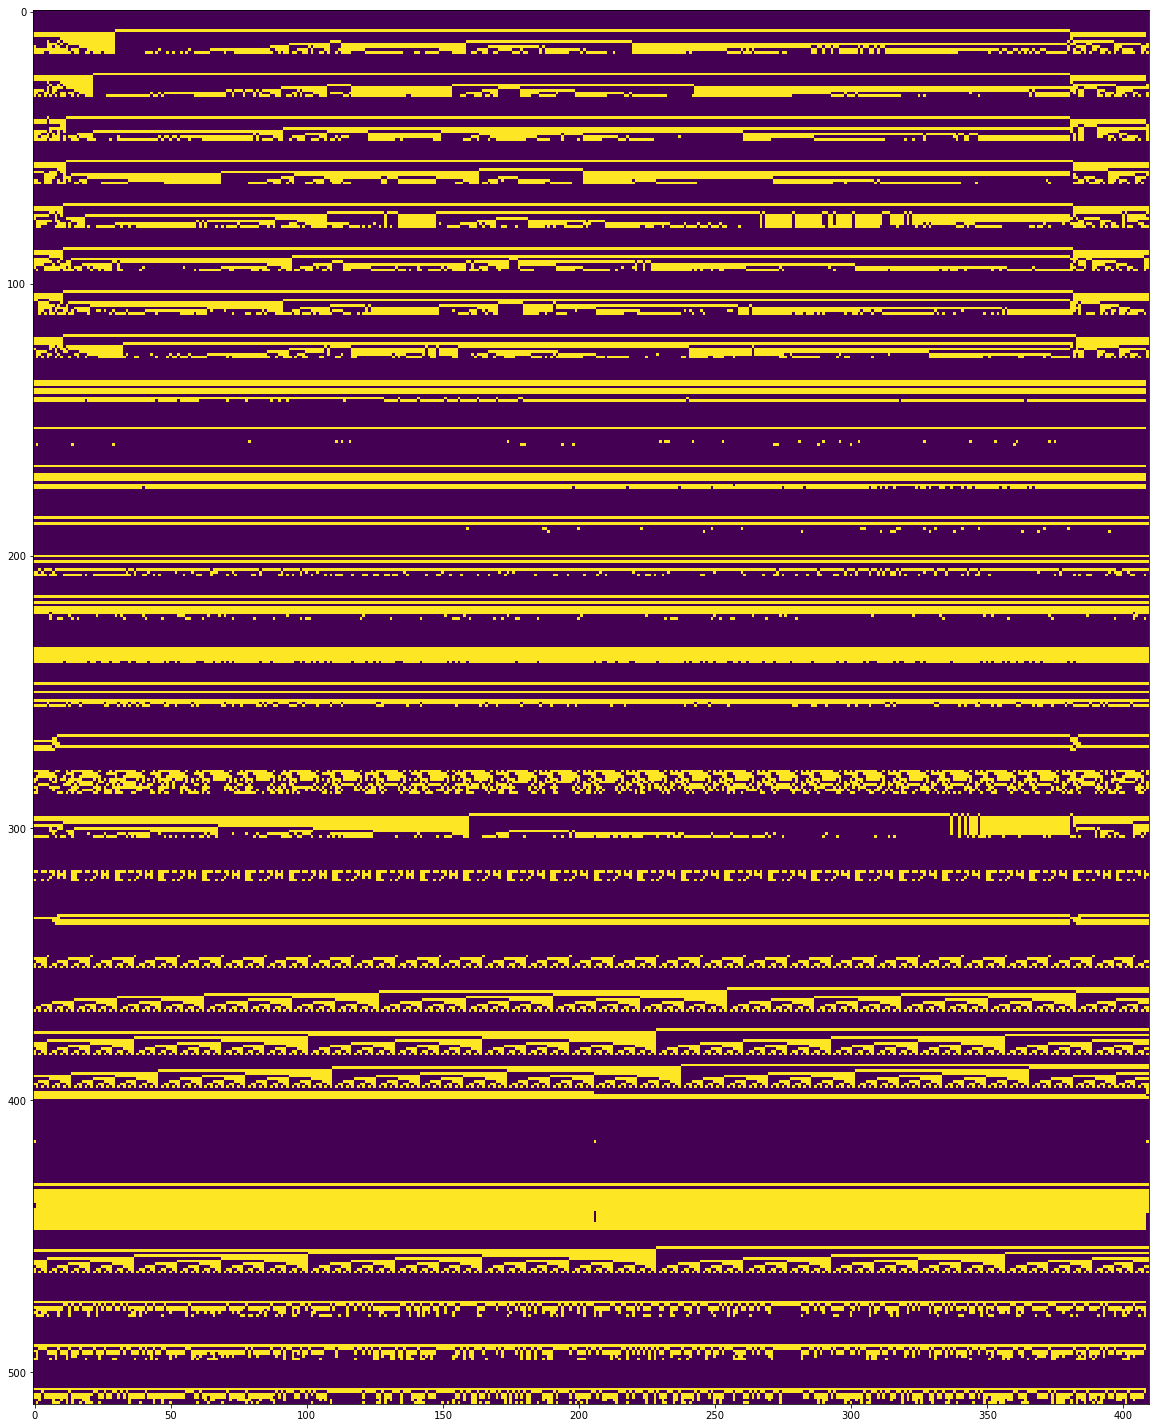

In [75]:
plt.figure(figsize=(20,40))
plt.imshow(np.transpose(rawbin[:period1*410].reshape((410,period1)))[512:1024])

Here, I'll plot the first 68 data channels as representative of the rest. 

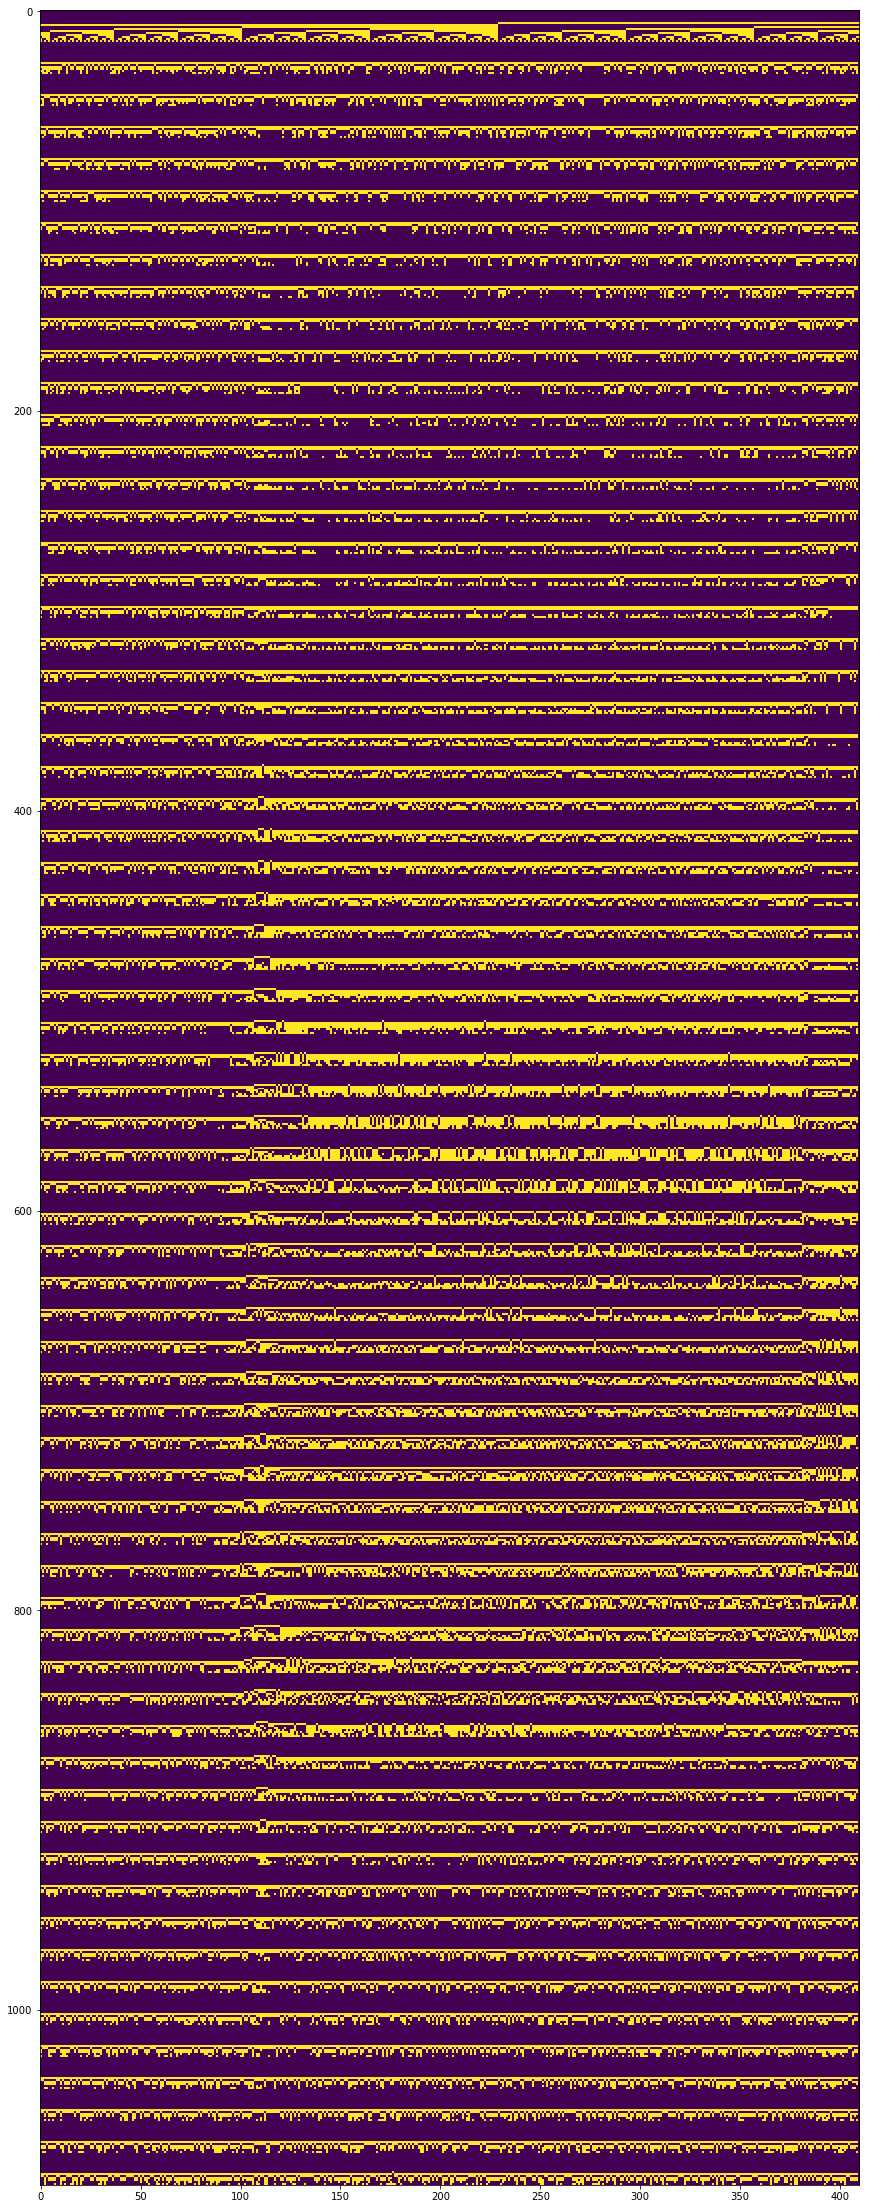

In [82]:
plt.figure(figsize=(20,40))
plt.imshow(np.transpose(rawbin[:period1*410].reshape((410,period1)))[1024-64:2048])

Let's take a look at the total data, since ripping it out shouldn't be that hard. First, the index corresponding to the last header channel.

In [111]:
frame_index=np.array([np.dot(rawbin[period1*j+960:period1*j+976],np.flip([2**i for i in range(16)],axis=0)) for j in range(410)])

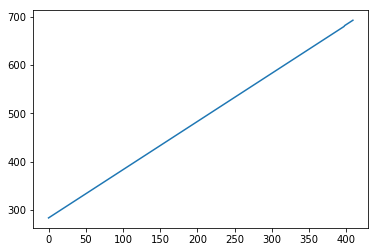

In [117]:
plt.plot(frame_index)

In [126]:
alldata = np.flip(np.array([np.array([np.dot(rawbin[period1*k+976+16*j:period1*k+992+16*j],np.flip([2**i for i in range(16)],axis=0)) for j in range(3840)]) for k in range(410)]),axis=1)

In [127]:
alldata.shape

(410, 3840)

This is basically the same spectrum as viking 1, but reversed left to right. Viking 1 was upside down (needed to be subtracted from 512). I have switched the orientation here for consistency.

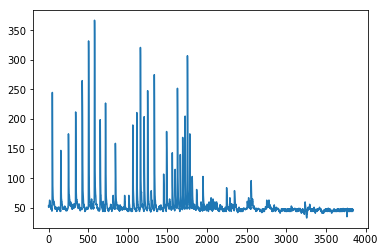

In [128]:
plt.plot(alldata[1])

Here is the total dataset. There are probably a few glitches. But it doesn't seem to have any of the pathological stuff that Viking 1 has. I think it's safe to assume this dataset was processed on the ground before being saved, while Viking 1 data may actually represent what came down from the spacecraft.

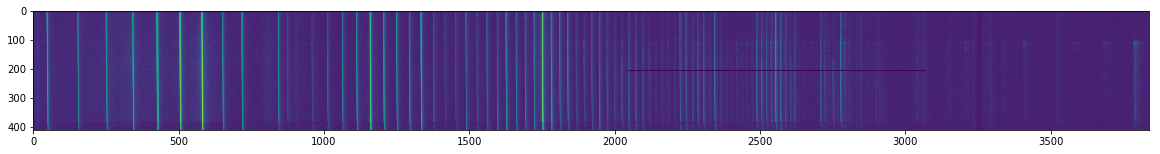

In [129]:
plt.figure(figsize=(20,10))
plt.imshow(alldata)

This figure is from Viking 1, so it's pretty comparable.

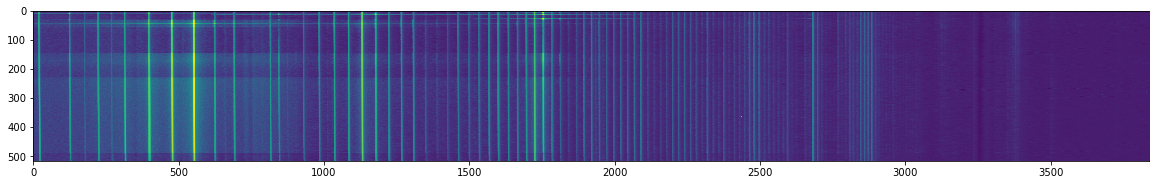

In [378]:
plt.figure(figsize=(20,10))
plt.imshow(512-alldata)

Save the raw data.

In [379]:
np.savetxt("./recoveredcsvs/DR005967_F0000"+str(1)+".csv",alldata,delimiter=',')


Calibration
Header data

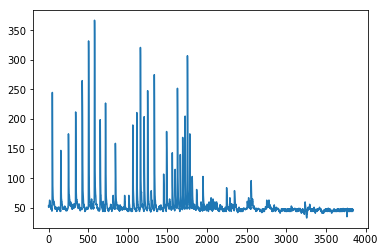

In [130]:
plt.plot(alldata[1])

According to the papers, the mass spectrometer performs exponential reductions in voltage from about 2300V to about 125V in 3840 steps, spanning masses from 12 to 215 AMU. In a mass spectrometer, the voltage is inversely proportional to mass, so in the graph above, mass is increasing from left to right.

In [183]:
vstep=(219/11.5)**(1/3839)

def MassToIndex(mass):
    return np.log(mass/11.5)/np.log(vstep)
    
def IndexToMass(index):
    return 11.5*vstep**index

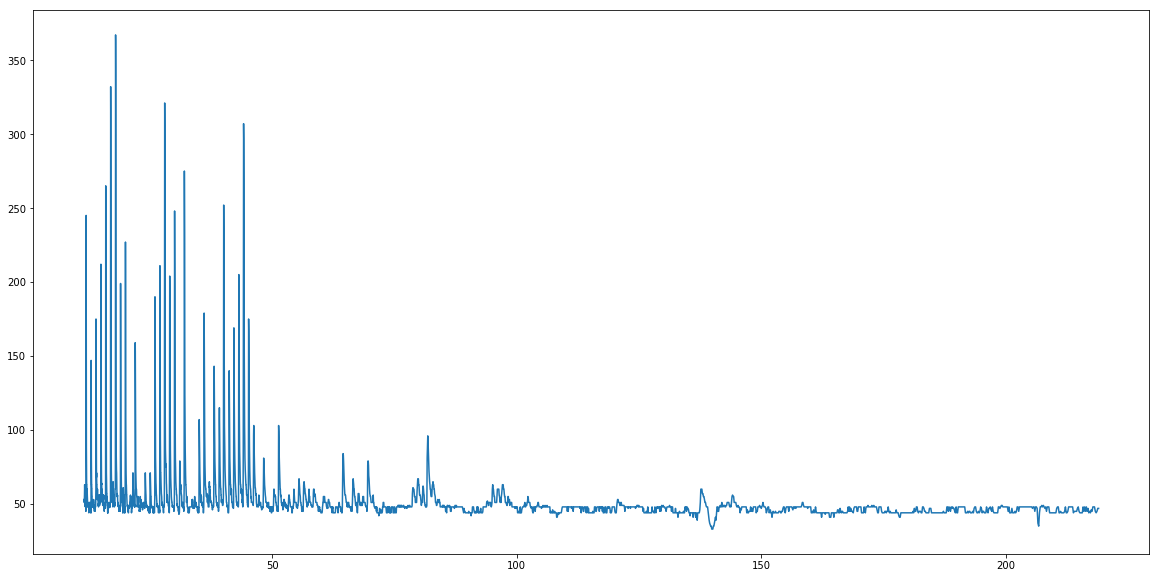

In [184]:
plt.figure(figsize=(20,10))
plt.plot([IndexToMass(i) for i in range(3840)],alldata[1])

To make this look like the microfilms, we need to take an appropriate exponential.

In [185]:
mask=np.concatenate((np.zeros(int(np.round(MassToIndex(47)))),1+np.zeros(3840-int(np.round(MassToIndex(47))))))

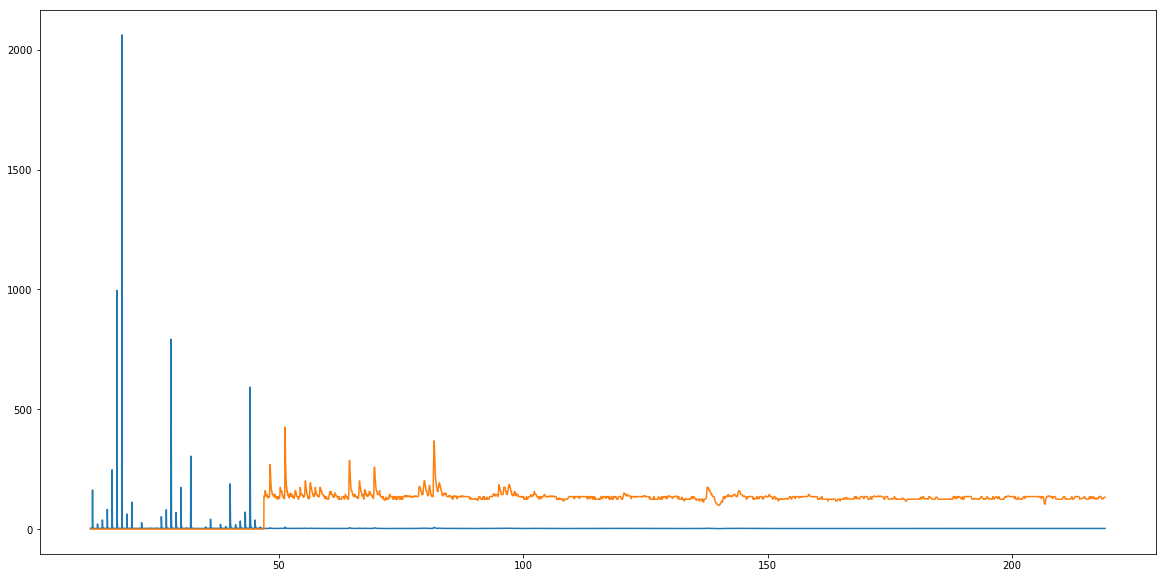

In [186]:
plt.figure(figsize=(20,10))
plt.plot([IndexToMass(i) for i in range(3840)],2**(0.03*(alldata[1])))
plt.plot([IndexToMass(i) for i in range(3840)],50*mask*2**(0.03*(alldata[1])))

As expected, the dominant peaks are found at M = 18, 28, and 44. (H2O, CO, CO2).

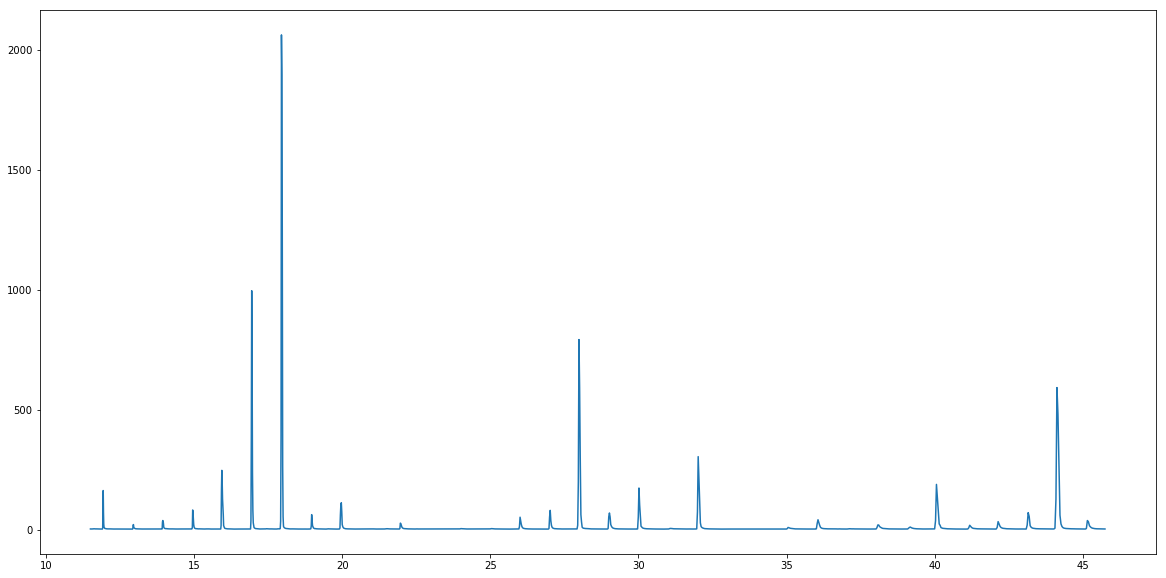

In [187]:
plt.figure(figsize=(20,10))
plt.plot([IndexToMass(i) for i in range(1800)],2**(0.03*(alldata[1][:1800])))

As the scan progresses, the number of bins per peak decreases. In the graph below, I compare taking a mean (above) vs taking a maximum (below) to determine absolute current flux in the spectrum. Probably we will have to compare to the microfilms to know what was done before.

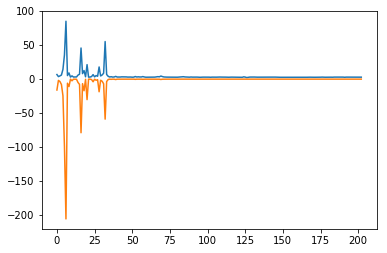

In [150]:
plt.plot([np.mean(2**(0.03*(alldata[1]))[int(np.max([np.ceil(MassToIndex(m-0.5)),0])):int(np.min([np.ceil(MassToIndex(m+0.5)),3839]))]) for m in range(12,215)])
plt.plot([-0.1*np.max(2**(0.03*(alldata[1]))[int(np.max([np.ceil(MassToIndex(m-0.5)),0])):int(np.min([np.ceil(MassToIndex(m+0.5)),3839]))]) for m in range(12,215)])

Let's graph the header data to see what's in there.

In [165]:
headerdata = np.transpose(np.array([np.array([np.dot(rawbin[period1*k+0+16*j:period1*k+16+16*j],np.flip([2**i for i in range(16)],axis=0)) for j in range(61)]) for k in range(410)]))

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


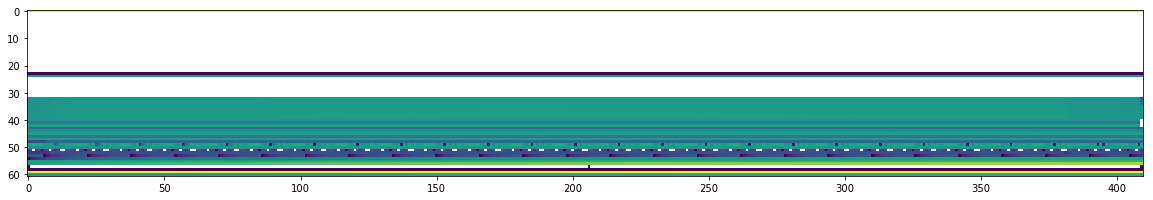

In [166]:
plt.figure(figsize=(20,10))
plt.imshow(np.log10(headerdata))

If we plot the time varying components of the header we see stuff that looks very similar to Viking 1. There is a mix of slowly varying numbers and also many different counters or apparent state registers.

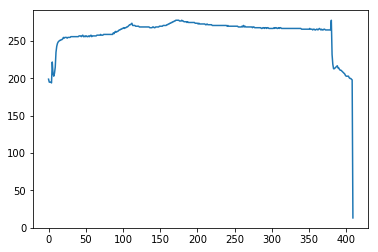

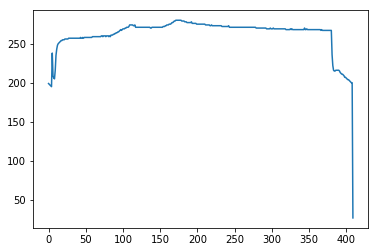

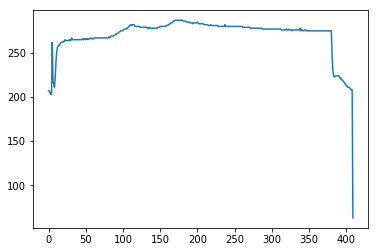

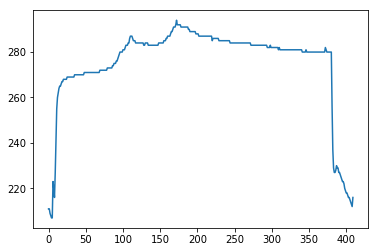

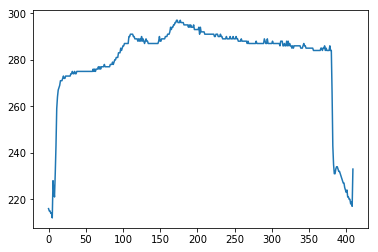

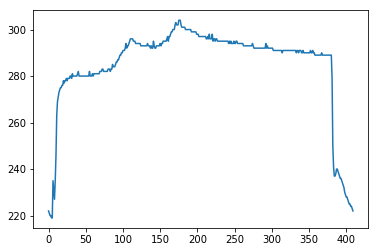

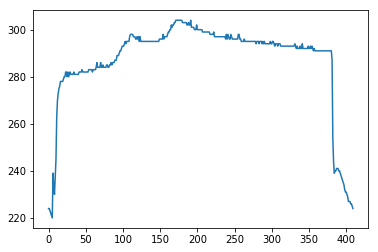

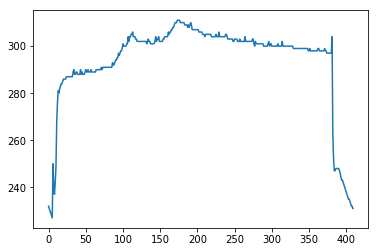

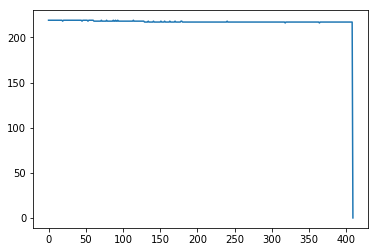

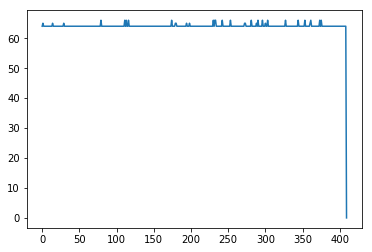

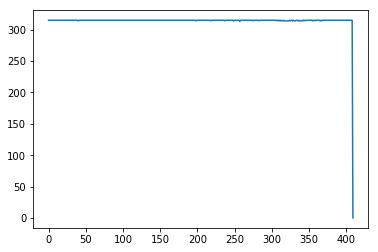

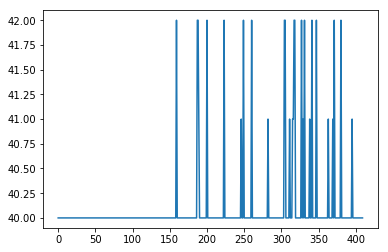

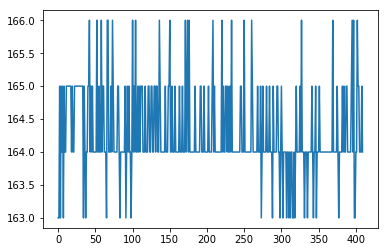

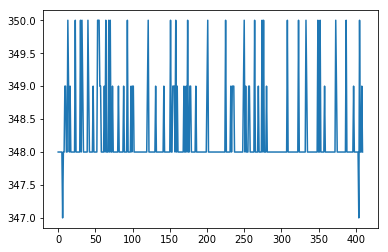

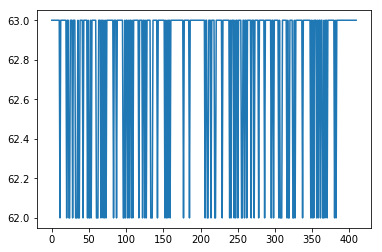

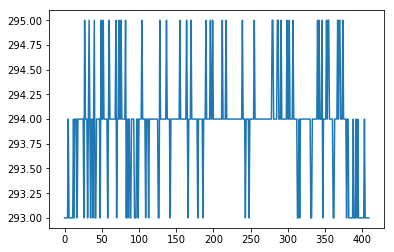

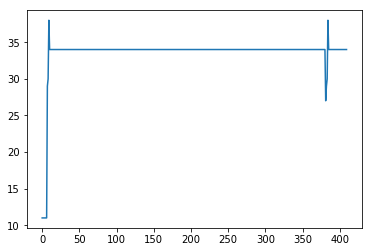

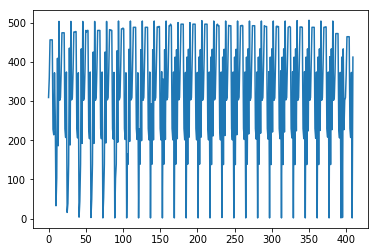

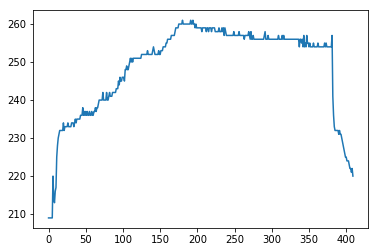

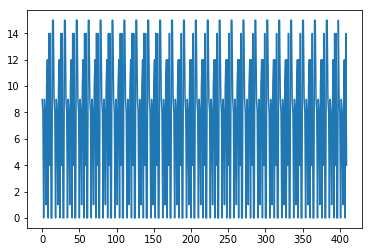

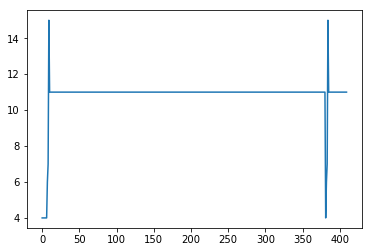

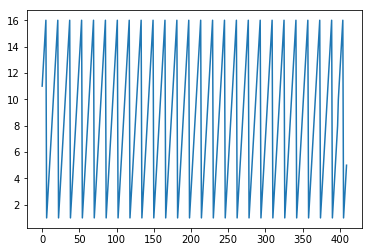

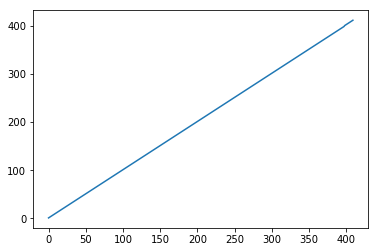

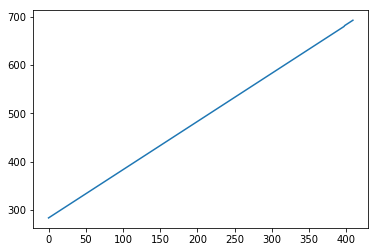

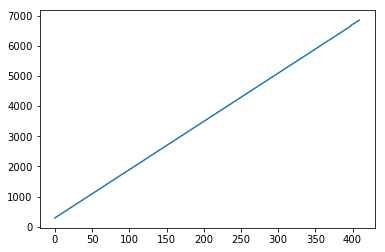

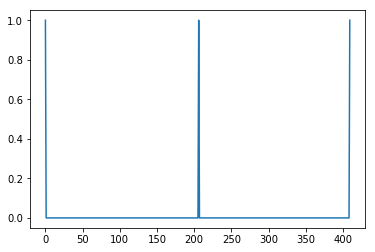

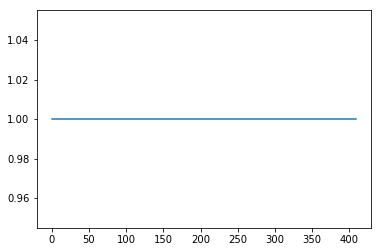

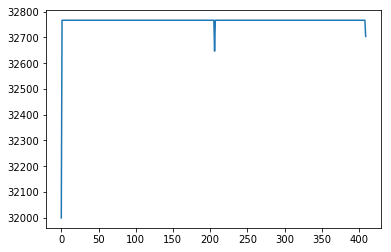

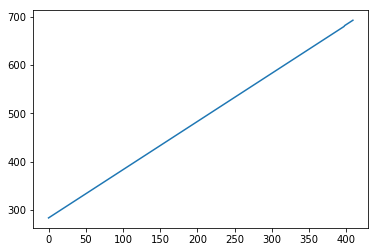

In [177]:
for i in range(32,61):
    plt.plot(headerdata[i])
    plt.show()